In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# For ML model training
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# If needed: download NLTK corpora (stopwords, wordnet, etc.)
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\himan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\himan\AppData\Roaming\nltk_data...


True

### DATA DESCRIPTION

In [3]:
train=pd.read_csv('data/train.csv')
test=pd.read_csv('data/test.csv')


Data shape: (7613, 5)
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
target
0    4342
1    3271
Name: count, dtype: int64


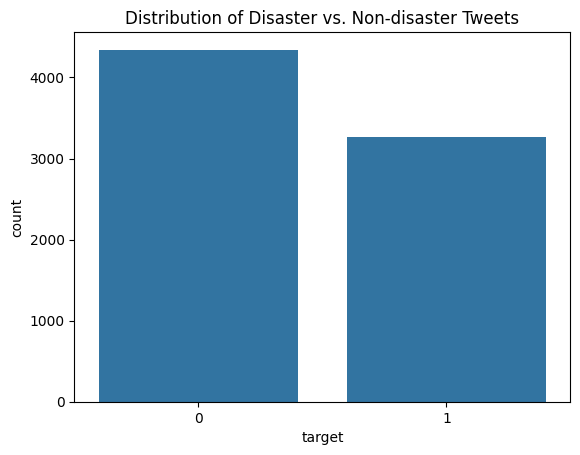

In [4]:
# Check the shape of the dataframe
print("Data shape:", train.shape)

# Check for null values
print(train.isnull().sum())

# Examine the distribution of the target
print(train['target'].value_counts())

# Plot the target distribution
sns.countplot(x='target', data=train)
plt.title("Distribution of Disaster vs. Non-disaster Tweets")
plt.show()


### PRE PROCESSING

In [6]:
# Example cleaning function
def clean_text(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 3. Remove user @ references and '#' from text
    text = re.sub(r'\@\w+|\#','', text)
    
    # 4. Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)
    
    # 5. Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # 6. Remove extra spaces
    text = text.strip()
    
    return text

# Initialize stopwords, stemmer/lemmatizer
stop_words = set(stopwords.words('english'))
ps = PorterStemmer() 
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = clean_text(text)
    # Tokenize
    words = text.split()
    
    # Remove stopwords and apply stemming/lemmatizing
    # You can choose either stemming or lemmatizing (or experiment)
    words = [ps.stem(word) for word in words if word not in stop_words]
    # OR: words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    return " ".join(words)



In [7]:
train['clean_text'] = train['text'].apply(preprocess_text)

# Check the cleaned text
train[['text', 'clean_text']].head()

,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquak may allah forgiv us
1,Forest fire near La Ronge Sask. Canada,forest fire near la rong sask canada
2,All residents asked to 'shelter in place' are ...,resid ask shelter place notifi offic evacu she...
3,"13,000 people receive #wildfires evacuation or...",peopl receiv wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo rubi alaska smoke wildfir pour ...


### Feature Extraction

In [10]:
# Split data into features (X) and target (y)
X = train['clean_text']
y = train['target']

# Split into train and test sets (80% train, 20% test)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # limit features to top 5000 (you can change as needed)

# Fit TF-IDF on the training data and transform both train and test
X_train_tfidf = tfidf.fit_transform(X_train)
X_valid_tfidf = tfidf.transform(X_valid)

print("Train TF-IDF shape:", X_train_tfidf.shape)
print("valid TF-IDF shape:", X_valid_tfidf.shape)


Train TF-IDF shape: (6090, 5000)
valid TF-IDF shape: (1523, 5000)


### MODELLING

In [12]:
# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

# Train (fit) the model
lr_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(X_valid_tfidf)

# Evaluate
accuracy_lr = accuracy_score(y_valid, y_pred_lr)
print("Logistic Regression Accuracy:", accuracy_lr)
print("Classification Report:\n", classification_report(y_valid, y_pred_lr))


Logistic Regression Accuracy: 0.8227183191070256
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.90      0.85       869
           1       0.85      0.72      0.78       654

    accuracy                           0.82      1523
   macro avg       0.83      0.81      0.81      1523
weighted avg       0.83      0.82      0.82      1523



In [13]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_valid_tfidf)

accuracy_nb = accuracy_score(y_valid, y_pred_nb)
print("Naive Bayes Accuracy:", accuracy_nb)
print("Classification Report:\n", classification_report(y_valid, y_pred_nb))


Naive Bayes Accuracy: 0.8135259356533159
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.91      0.85       869
           1       0.85      0.69      0.76       654

    accuracy                           0.81      1523
   macro avg       0.82      0.80      0.80      1523
weighted avg       0.82      0.81      0.81      1523



In [14]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_valid_tfidf)

accuracy_rf = accuracy_score(y_valid, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)
print("Classification Report:\n", classification_report(y_valid, y_pred_rf))


Random Forest Accuracy: 0.7957977675640184
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83       869
           1       0.79      0.71      0.75       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.79      1523



In [16]:
cf_matrix_lr = confusion_matrix(y_valid, y_pred_lr)
cf_matrix_nb = confusion_matrix(y_valid, y_pred_nb)
cf_matrix_rf = confusion_matrix(y_valid, y_pred_rf)

print("Confusion Matrix (Logistic Regression):\n", cf_matrix_lr)
print("Confusion Matrix (Naive Bayes):\n", cf_matrix_nb)
print("Confusion Matrix (Random Forest):\n", cf_matrix_rf)


Confusion Matrix (Logistic Regression):
 [[784  85]
 [185 469]]
Confusion Matrix (Naive Bayes):
 [[787  82]
 [202 452]]
Confusion Matrix (Random Forest):
 [[747 122]
 [189 465]]


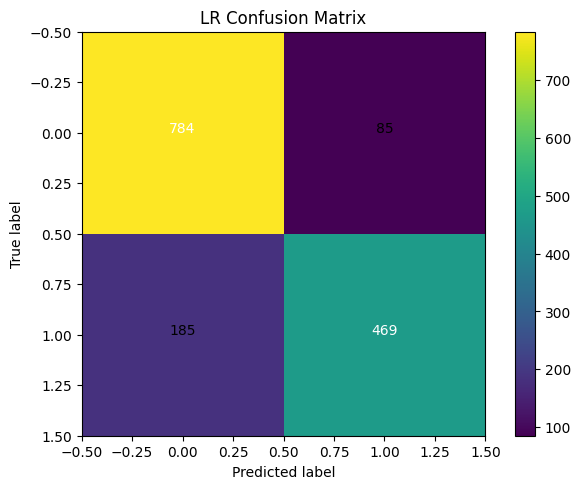

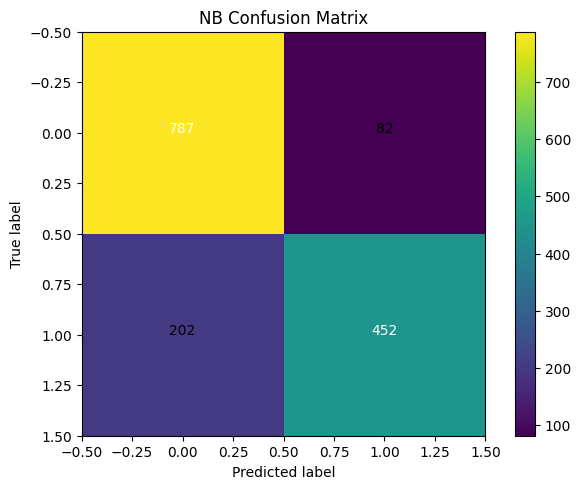

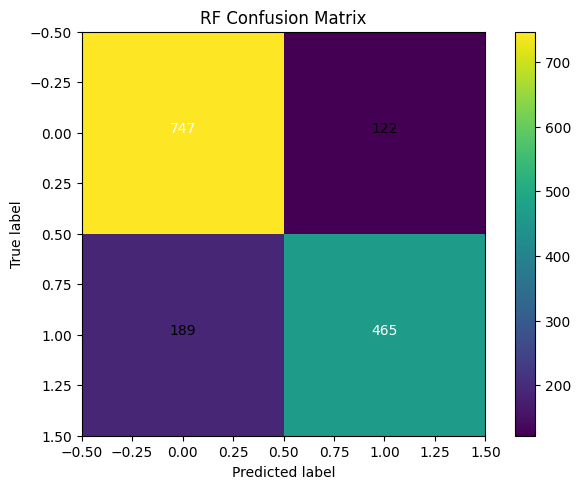

In [17]:
import itertools

def plot_confusion_matrix(cm, title='Confusion matrix'):
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Example usage:
plot_confusion_matrix(cf_matrix_lr, title='LR Confusion Matrix')
plot_confusion_matrix(cf_matrix_nb, title='NB Confusion Matrix')
plot_confusion_matrix(cf_matrix_rf, title='RF Confusion Matrix')


In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # 'l1' may require a different solver
}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, n_jobs=-1, verbose=1)
grid_lr.fit(X_train_tfidf, y_train)

print("Best parameters:", grid_lr.best_params_)
print("Best cross-validation score:", grid_lr.best_score_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'C': 1, 'penalty': 'l2'}
Best cross-validation score: 0.7954022988505747


## MAKING PREDICTIONS

In [20]:
test['clean_text'] = test['text'].apply(preprocess_text)
test.set_index('id', inplace=True)
X_test_tfidf = tfidf.transform(test['clean_text'])
predictions = lr_model.predict(X_test_tfidf)
predictions

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [24]:
submission = pd.DataFrame({'id': test.index, 'target': predictions})
submission.to_csv('Results/submission.csv', index=False)
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
